In [1]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [2]:
# Download data
# Images and annotations
# For annotations every pixel is labelled as a pet or part of a background
# Binary classification
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0  755M    0 2604k    0     0  2604k      0  0:04:56  0:00:01  0:04:55 1423k
  1  755M    1 8562k    0     0  4281k      0  0:03:00  0:00:02  0:02:58 3026k
  1  755M    1 13.9M    0     0  4760k      0  0:02:42  0:00:03  0:02:39 3729k
  2  755M    2 19.7M    0     0  5064k      0  0:02:32  0:00:04  0:02:28 4195k
  3  755M    3 25.8M    0     0  5295k      0  0:02:26  0:00:05  0:02:21 5704k
  4  755M    4 32.2M    0     0  5512k      0  0:02:20  0:00:06  0:02:14 6094k
  5  755M    5 39.0M    0     0  5717k      0  0:02:15  0:00:07  0:02:08 6292k
  6  755M    6 46.0M    0     0  5889k      0  0:02:11  0:00:08  0:02:03 6567k
  7  755M    7 53.2M    0     0  6063k      0  0:02

In [4]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")]
)

target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


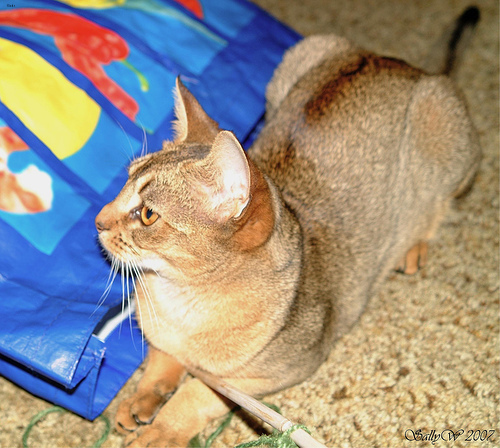

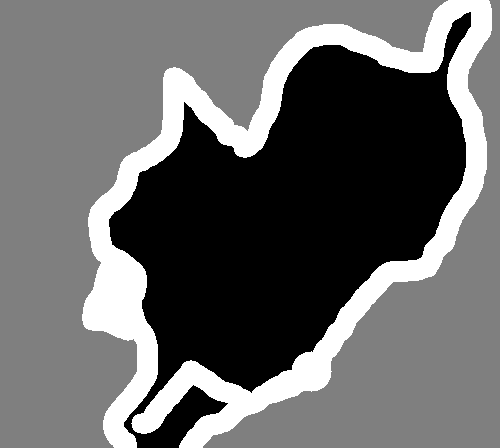

In [8]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

display(Image(filename=input_img_paths[9]))

img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [9]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

# Sequence class to load a vectorize batches of data

# Sequence class vs tf.data?

class OxfordPets(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths


    def __len__(self):
        # returns number of batches
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")

        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img,2) #??
             # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

In [38]:
#Prepare U-Net Xception-style model

# https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
# Separable convolutions - spatial separable and depthwise separable

# Spatial separable conv - divide 3x3 kernel into 3x1 and 1x3 kernel, instead of 9 multiplications 3 multiplications are done twice

# Depthwise separable conv - works with kernels that can't be divided spatially 
# tf.keras.layers.SeparableConv2D uses depthwise conv
# Depthwise conv separates kernel into 2 convolutions - depthwise and pointwise

# Instead of doing 5x5 kernels with 3 channels 256 times we do 5x5x1 for each channel and then 256 1x1xnumber_of_channels kernels 
# This way we much less multiplications but having less parameters can lead to worse training,
# if the architecture is simple already probably don't use it


from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    # Entry block
    x = layers.Conv2D(32,3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x # skip connection?

    # Downsampling

    for filters in [64, 128, 256]:
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual]) # Add back residual
        previous_block_activation = x # Set aside next residual

        x = layers.Activation("relu")(x)

    # Upsampling
    for filters in [256, 128, 64, 32]:
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual]) # add back residual
        previous_block_activation = x # Set aside next residual
        x = layers.Activation("relu")(x)

    # Add a per pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)

    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
model = get_model(img_size, num_classes)



In [33]:
# This architecture is originally in the tutorial: https://keras.io/examples/vision/oxford_pets_image_segmentation/
# Above I have changed the position of activation so there arent 2 activations right after each other when coming to first block from entry block

# from tensorflow.keras import layers


# def get_model(img_size, num_classes):
#     inputs = keras.Input(shape=img_size + (3,))

#     ### [First half of the network: downsampling inputs] ###

#     # Entry block
#     x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     previous_block_activation = x  # Set aside residual

#     # Blocks 1, 2, 3 are identical apart from the feature depth.
#     for filters in [64, 128, 256]:
#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

#         # Project residual
#         residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
#             previous_block_activation
#         )
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     ### [Second half of the network: upsampling inputs] ###

#     for filters in [256, 128, 64, 32]:
#         x = layers.Activation("relu")(x)
#         x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
#         x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.UpSampling2D(2)(x)

#         # Project residual
#         residual = layers.UpSampling2D(2)(previous_block_activation)
#         residual = layers.Conv2D(filters, 1, padding="same")(residual)
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     # Add a per-pixel classification layer
#     outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

#     # Define the model
#     model = keras.Model(inputs, outputs)
#     return model


# # Free up RAM in case the model definition cells were run multiple times
# keras.backend.clear_session()

# # Build model
# model = get_model(img_size, num_classes)

In [16]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [39]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]

# Train the model, doing validation at the end of each epoch.
epochs = 30
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/30
199/199 [==============================] - 39s 179ms/step - loss: 0.7741 - val_loss: 2.3030
Epoch 2/30
199/199 [==============================] - 32s 163ms/step - loss: 0.4892 - val_loss: 2.0345
Epoch 3/30
199/199 [==============================] - 31s 158ms/step - loss: 0.4189 - val_loss: 0.4984
Epoch 4/30
199/199 [==============================] - 37s 185ms/step - loss: 0.3766 - val_loss: 0.4188
Epoch 5/30
199/199 [==============================] - 39s 194ms/step - loss: 0.3417 - val_loss: 0.4434
Epoch 6/30
199/199 [==============================] - 33s 166ms/step - loss: 0.3146 - val_loss: 0.6744
Epoch 7/30
199/199 [==============================] - 34s 173ms/step - loss: 0.2914 - val_loss: 0.4458


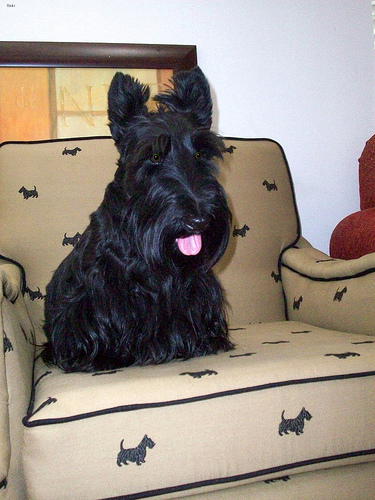

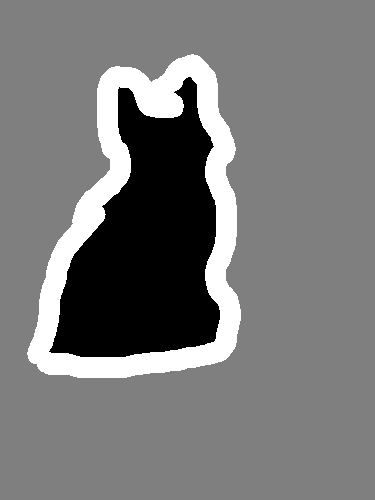

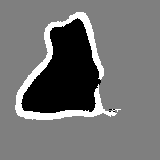

In [37]:
val_preds = model.predict(val_gen)

def display_mask(i):
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


i = 17

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.
